# ============================
# Enhanced Denoising Autoencoder
# ============================

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Imports ---
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, precision_recall_curve, auc

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [ ]:
# --- Paths ---
DATA_DIR = Path("/content/drive/MyDrive/zeusOps/data/CIC-IDS-2017")
MODEL_DIR = Path("/content/drive/MyDrive/zeusOps/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# --- Load preprocessed (scaled) data ---
X_train = pd.read_pickle(DATA_DIR / "cicids_x_train.pkl").values.astype("float32")
X_test  = pd.read_pickle(DATA_DIR / "cicids_x_test.pkl").values.astype("float32")
y_train_raw = np.array(pd.read_pickle(DATA_DIR / "cicids_y_train.pkl")).ravel()
y_test_raw  = np.array(pd.read_pickle(DATA_DIR / "cicids_y_test.pkl")).ravel()

In [ ]:
# --- Split validation set from training ---
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_raw, y_val_raw = train_test_split(
    X_train, y_train_raw, test_size=0.1, random_state=42, stratify=y_train_raw
)

# --- Detect normal label and binarize labels ---
unique, counts = np.unique(y_train_raw, return_counts=True)
normal_label = unique[np.argmax(counts)]
print("Detected normal label (treated as normal):", normal_label)

y_train = np.where(y_train_raw == normal_label, 0, 1)
y_val   = np.where(y_val_raw   == normal_label, 0, 1)
y_test  = np.where(y_test_raw  == normal_label, 0, 1)

In [ ]:
# --- Noise injection helper ---
def add_noise(X, noise_factor=0.05):
    noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
    return np.clip(noisy, 0., 1.)

# --- Denoising Autoencoder Architecture ---
input_dim = X_train.shape[1]
latent_dim = 32

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu', kernel_regularizer=l2(1e-5))(input_layer)
encoded = Dropout(0.3)(encoded)
encoded = Dense(64, activation='relu', kernel_regularizer=l2(1e-5))(encoded)
encoded = Dropout(0.3)(encoded)
bottleneck = Dense(latent_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(bottleneck)
decoded = Dropout(0.3)(decoded)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

dae = Model(inputs=input_layer, outputs=output_layer)
dae.compile(optimizer=Adam(learning_rate=1e-4, clipvalue=1.0), loss='mse')
dae.summary()

# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]


In [ ]:
# --- Train Denoising Autoencoder ---
X_train_noisy = add_noise(X_train, noise_factor=0.05)
X_val_noisy   = add_noise(X_val, noise_factor=0.05)

history = dae.fit(
    X_train_noisy, X_train,
    validation_data=(X_val_noisy, X_val),
    epochs=100,
    batch_size=256,
    shuffle=True,
    callbacks=callbacks,
    verbose=2
)

# --- Save model & results ---
dae.save(MODEL_DIR / "cicids_dae_model.h5")
print("Saved DAE model to:", MODEL_DIR / "cicids_dae_model.h5")

In [ ]:
# --- Plot Training Loss ---
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Denoising Autoencoder Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [ ]:
# --- Compute reconstruction MSE ---
recon_val = dae.predict(X_val)
mse_val = np.mean(np.square(X_val - recon_val), axis=1)

recon_test = dae.predict(X_test)
mse_test = np.mean(np.square(X_test - recon_test), axis=1)

In [ ]:
# ============================
# Threshold Selection Methods
# ============================

results = []

# 1) Percentile-based thresholds
percentiles = [75, 80, 85, 90, 95]
for pct in percentiles:
    thr = np.percentile(mse_val, pct)
    y_pred = (mse_test >= thr).astype(int)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, mse_test)
    acc = (y_pred == y_test).mean()
    results.append(["Percentile-"+str(pct), thr, f1, roc_auc, acc])

# 2) Youden’s J statistic (ROC-based)
fpr, tpr, thresholds = precision_recall_curve(y_val, mse_val)
# careful: precision_recall_curve returns precision/recall, not fpr/tpr
# Let's use ROC curve instead
from sklearn.metrics import roc_curve
fpr, tpr, thr_roc = roc_curve(y_val, mse_val)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
youden_thr = thr_roc[best_idx]
y_pred = (mse_test >= youden_thr).astype(int)
results.append([
    "YoudenJ", youden_thr,
    f1_score(y_test, y_pred),
    roc_auc_score(y_test, mse_test),
    (y_pred == y_test).mean()
])

# 3) Best F1 from precision-recall curve
prec, rec, thr_pr = precision_recall_curve(y_val, mse_val)
f1s = 2*prec*rec / (prec+rec+1e-6)
best_idx = np.argmax(f1s)
f1_thr = thr_pr[best_idx]
y_pred = (mse_test >= f1_thr).astype(int)
results.append([
    "BestF1_PR", f1_thr,
    f1_score(y_test, y_pred),
    roc_auc_score(y_test, mse_test),
    (y_pred == y_test).mean()
])


In [ ]:
# --- Collect results into DataFrame ---
results_df = pd.DataFrame(results, columns=["Method", "Threshold", "F1", "ROC-AUC", "Accuracy"])
print("\n=== Threshold Comparison ===")
print(results_df)


=== Threshold Comparison ===
          Method     Threshold        F1   ROC-AUC  Accuracy
0  Percentile-75  6.298101e+13  0.424812  0.722818  0.758698
1  Percentile-80  7.459764e+27  0.424114  0.722818  0.787171
2  Percentile-85  1.736282e+28  0.450280  0.722818  0.823819
3  Percentile-90  2.223971e+29  0.487887  0.722818  0.862056
4  Percentile-95  1.279234e+30  0.402194  0.722818  0.868846
5        YoudenJ  1.845925e+28  0.497183  0.722818  0.856011
6      BestF1_PR  1.845925e+28  0.497183  0.722818  0.856011


In [ ]:
# --- Pick best method ---
best_row = results_df.loc[results_df["F1"].idxmax()]
print("\n>>> Best Choice:", best_row.to_dict())

# --- Final Predictions & Evaluation ---
final_thr = best_row["Threshold"]
y_pred_best = (mse_test >= final_thr).astype(int)
cm = confusion_matrix(y_test, y_pred_best)


>>> Best Choice: {'Method': 'YoudenJ', 'Threshold': 1.8459253622522673e+28, 'F1': 0.4971831766379135, 'ROC-AUC': 0.722818318468692, 'Accuracy': 0.8560112982097944}


In [ ]:
# # --- Threshold Selection using percentiles ---
# percentiles = [75, 80, 85, 90, 95]
# best_f1 = -1
# best_thr = None

# for pct in percentiles:
#     thr = np.percentile(mse_val, pct)
#     y_pred = (mse_test >= thr).astype(int)
#     f1 = f1_score(y_test, y_pred)
#     print(f"Percentile {pct}th -> Threshold: {thr:.6f}, F1: {f1:.4f}")
#     if f1 > best_f1:
#         best_f1 = f1
#         best_thr = thr

# print(f"\nBest threshold based on max F1: {best_thr:.6f}  (F1={best_f1:.4f})")

# # --- Final Predictions & Evaluation ---
# y_pred_best = (mse_test >= best_thr).astype(int)
# cm = confusion_matrix(y_test, y_pred_best)
# f1 = f1_score(y_test, y_pred_best)
# roc_auc = roc_auc_score(y_test, mse_test)
# acc = (cm[0,0] + cm[1,1]) / cm.sum()


In [ ]:
print("\n=== Evaluation at Best Threshold ===")
print("Confusion Matrix:\n", cm)


=== Evaluation at Best Threshold ===
Confusion Matrix:
 [[593504  35014]
 [ 73874  53834]]


In [ ]:
print(classification_report(y_test, y_pred_best, target_names=['normal','attack']))

              precision    recall  f1-score   support

      normal       0.89      0.94      0.92    628518
      attack       0.61      0.42      0.50    127708

    accuracy                           0.86    756226
   macro avg       0.75      0.68      0.71    756226
weighted avg       0.84      0.86      0.85    756226



In [ ]:
print(f"Accuracy: {best_row['Accuracy']:.4f}, F1: {best_row['F1']:.4f}, ROC-AUC: {best_row['ROC-AUC']:.4f}")

Accuracy: 0.8560, F1: 0.4972, ROC-AUC: 0.7228


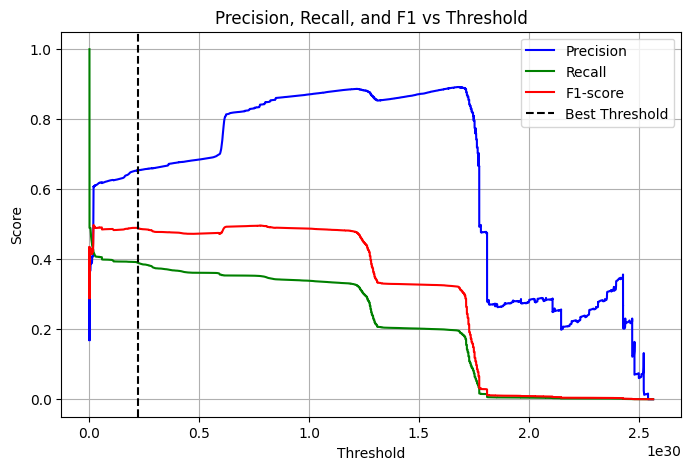

Max F1 from PR-Curve: 0.4972


In [ ]:
# --- Precision-Recall Curve & Threshold Analysis ---
precisions, recalls, thresholds = precision_recall_curve(y_test, mse_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions[:-1], label="Precision", color="blue")
plt.plot(thresholds, recalls[:-1], label="Recall", color="green")
plt.plot(thresholds, f1_scores[:-1], label="F1-score", color="red")
plt.axvline(x=best_thr, color="black", linestyle="--", label="Best Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

print(f"Max F1 from PR-Curve: {np.max(f1_scores):.4f}")


In [ ]:
results_save = pd.DataFrame({
    "mse_test": mse_test,
    "y_test": y_test,
    "y_pred_best": y_pred_best
})
results_save.to_pickle(MODEL_DIR / "dae_cicids_test2_results.pkl")
print("Saved test results to:", MODEL_DIR / "dae_cicids_test_results2.pkl")

Detected normal label (treated as normal): 4


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 52)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 52)             │         6,708 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,260 (133.83 KB)

 Trainable params: 34,260 (133.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
6204/6204 - 42s - 7ms/step - loss: 29257019424768.0000 - val_loss: 16719268544512.0000 - learning_rate: 1.0000e-04
Epoch 2/100
6204/6204 - 43s - 7ms/step - loss: 10948567891968.0000 - val_loss: 7056019423232.0000 - learning_rate: 1.0000e-04
Epoch 3/100
6204/6204 - 40s - 6ms/step - loss: 7373703872512.0000 - val_loss: 6218507616256.0000 - learning_rate: 1.0000e-04
Epoch 4/100
6204/6204 - 40s - 6ms/step - loss: 6808635179008.0000 - val_loss: 5794131607552.0000 - learning_rate: 1.0000e-04
Epoch 5/100
6204/6204 - 40s - 6ms/step - loss: 6459242840064.0000 - val_loss: 5520156524544.0000 - learning_rate: 1.0000e-04
Epoch 6/100
6204/6204 - 40s - 6ms/step - loss: 6211624763392.0000 - val_loss: 5299380420608.0000 - learning_rate: 1.0000e-04
Epoch 7/100
6204/6204 - 40s - 6ms/step - loss: 6049902886912.0000 - val_loss: 5176226742272.0000 - learning_rate: 1.0000e-04
Epoch 8/100
6204/6204 - 39s - 6ms/step - loss: 5946011025408.0000 - val_loss: 5086245814272.0000 - learning_rate: 1.0000e-

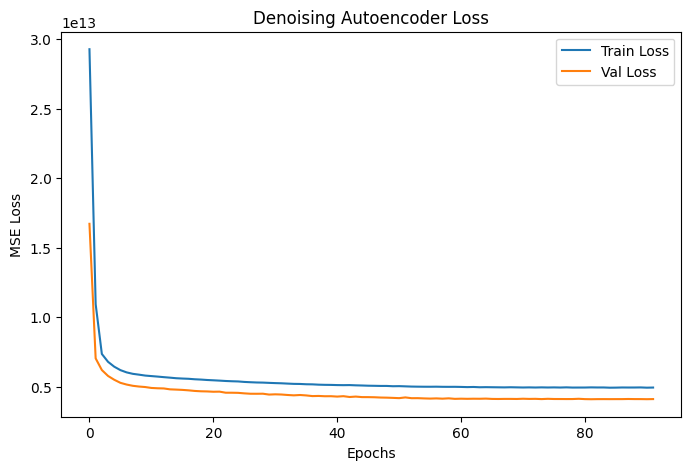

5515/5515 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
23633/23633 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
Percentile 75th -> Threshold: 62981006163968.000000, F1: 0.4248
Percentile 80th -> Threshold: 7459763543416192052255260672.000000, F1: 0.4241
Percentile 85th -> Threshold: 17362815753121619797866446848.000000, F1: 0.4503
Percentile 90th -> Threshold: 222397110538185876944789176320.000000, F1: 0.4879
Percentile 95th -> Threshold: 1279233771853139519105503592448.000000, F1: 0.4022

Best threshold based on max F1: 222397110538185876944789176320.000000  (F1=0.4879)



=== Evaluation at Best Threshold ===
Confusion Matrix:
 [[602218  26300]
 [ 78017  49691]]
              precision    recall  f1-score   support

      normal       0.89      0.96      0.92    628518
      attack       0.65      0.39      0.49    127708

    accuracy                           0.86    756226
   macro avg       0.77      0.67      0.70    756226
weighted avg       0.85      0.86      0.85    756226

Accuracy: 0.8621, F1: 0.4879, ROC-AUC: 0.7228
Saved DAE model to: /content/drive/MyDrive/zeusOps/models/dae_cicids_model.h5
Saved test results to: /content/drive/MyDrive/zeusOps/models/dae_cicids_test_results.pkl


In [ ]:
# # ==========================
# # DENOISING AUTOENCODER - CIC-IDS
# # WITH BEST THRESHOLD AUTOMATION + PLOTS
# # ==========================

# # --- Imports ---
# import numpy as np
# import pandas as pd
# from pathlib import Path
# import matplotlib.pyplot as plt

# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import callbacks

# from sklearn.metrics import (confusion_matrix, classification_report,
#                              f1_score, roc_auc_score, roc_curve,
#                              precision_recall_curve)

# # --- Paths ---
# DATA_DIR = Path("/content/drive/MyDrive/zeusOps/data/CIC-IDS-2017")
# MODEL_DIR = Path("/content/drive/MyDrive/zeusOps/models")
# MODEL_DIR.mkdir(parents=True, exist_ok=True)

# # --- Load preprocessed data ---
# x_train_df = pd.read_pickle(DATA_DIR / "cicids_x_train.pkl")
# x_test_df  = pd.read_pickle(DATA_DIR / "cicids_x_test.pkl")
# y_train_df = pd.read_pickle(DATA_DIR / "cicids_y_train.pkl")
# y_test_df  = pd.read_pickle(DATA_DIR / "cicids_y_test.pkl")

# X_train = x_train_df.values.astype("float32")
# X_test  = x_test_df.values.astype("float32")
# y_train_raw = np.array(y_train_df).ravel()
# y_test_raw  = np.array(y_test_df).ravel()

# # --- Detect normal label (majority class) and create binary labels ---
# unique, counts = np.unique(y_train_raw, return_counts=True)
# normal_label = unique[np.argmax(counts)]
# print("Detected normal label (treated as normal):", normal_label)

# y_train_binary = np.where(y_train_raw == normal_label, 0, 1)
# y_test_binary  = np.where(y_test_raw  == normal_label, 0, 1)

# # --- Prepare AE training data: only normal samples ---
# X_train_normals = X_train[y_train_binary == 0]

# # --- Shuffle & split normals into AE train / val ---
# SEED = 42
# rng = np.random.default_rng(SEED)
# idx = np.arange(X_train_normals.shape[0])
# rng.shuffle(idx)
# X_shuf = X_train_normals[idx]
# val_frac = 0.10
# val_size = max(1, int(val_frac * X_shuf.shape[0]))
# X_val = X_shuf[:val_size]
# X_ae_train = X_shuf[val_size:]

# print("AE train:", X_ae_train.shape, "AE val:", X_val.shape)

# # --- Add noise helper ---
# def add_noise(X, noise_factor=0.05):
#     noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
#     return np.clip(noisy, 0., 1.)

# X_train_noisy = add_noise(X_ae_train, noise_factor=0.05)
# X_val_noisy   = add_noise(X_val, noise_factor=0.05)

# # --- Build Denoising Autoencoder ---
# input_dim = X_train.shape[1]

# input_layer = Input(shape=(input_dim,))
# encoded = Dense(128, activation="relu")(input_layer)
# encoded = Dense(64, activation="relu")(encoded)
# bottleneck = Dense(32, activation="relu")(encoded)
# decoded = Dense(64, activation="relu")(bottleneck)
# decoded = Dense(128, activation="relu")(decoded)
# output_layer = Dense(input_dim, activation="sigmoid")(decoded)

# dae = Model(inputs=input_layer, outputs=output_layer)
# dae.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")
# dae.summary()

# # --- Early stopping ---
# es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # --- Train DAE ---
# history_dae = dae.fit(
#     X_train_noisy, X_ae_train,
#     epochs=50,
#     batch_size=256,
#     validation_data=(X_val_noisy, X_val),
#     shuffle=True,
#     callbacks=[es],
#     verbose=2
# )

# # --- Save DAE model ---
# dae.save(MODEL_DIR / "cicids_denoising_autoencoder.h5")
# print("Saved DAE to:", MODEL_DIR / "cicids_denoising_autoencoder.h5")

# # --- Compute reconstruction errors ---
# recon_val_dae  = dae.predict(X_val)
# mse_val_dae    = np.mean(np.square(X_val - recon_val_dae), axis=1)

# recon_test_dae = dae.predict(X_test)
# mse_test_dae   = np.mean(np.square(X_test - recon_test_dae), axis=1)

# # --- Automatically find best threshold (percentile) on val set ---
# percentiles = np.arange(75, 96, 1)  # 75th to 95th percentile
# best_f1 = -1
# best_thr = None

# for pct in percentiles:
#     thr = np.percentile(mse_val_dae, pct)
#     y_pred = (mse_test_dae >= thr).astype(int)
#     f1 = f1_score(y_test_binary, y_pred)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_thr = thr

# print(f"\nBest threshold based on max F1: {best_thr:.6f}  (F1={best_f1:.4f})")

# # --- Predictions using best threshold ---
# y_pred_best = (mse_test_dae >= best_thr).astype(int)

# # --- Evaluation ---
# cm = confusion_matrix(y_test_binary, y_pred_best)
# f1 = f1_score(y_test_binary, y_pred_best)
# roc_auc = roc_auc_score(y_test_binary, mse_test_dae)
# acc = (cm[0,0] + cm[1,1]) / cm.sum()

# print("\n--- Evaluation (Best Threshold) ---")
# print("Confusion matrix:\n", cm)
# print(classification_report(y_test_binary, y_pred_best, target_names=['normal','attack']))
# print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC-AUC (MSE): {roc_auc:.4f}")

# # --- ROC Curve ---
# fpr, tpr, _ = roc_curve(y_test_binary, mse_test_dae)
# plt.figure(figsize=(6,6))
# plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
# plt.plot([0,1],[0,1],'--', color='gray')
# plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
# plt.title("ROC Curve - Denoising Autoencoder")
# plt.legend()
# plt.show()

# # --- Precision-Recall Curve ---
# prec, rec, _ = precision_recall_curve(y_test_binary, mse_test_dae)
# plt.figure(figsize=(6,6))
# plt.plot(rec, prec)
# plt.xlabel("Recall"); plt.ylabel("Precision")
# plt.title("Precision-Recall Curve - Denoising Autoencoder")
# plt.show()
